In [1]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import glob
import datetime

%matplotlib inline

In [2]:
date_start = '2017-01-01'
date_end   = '2017-04-21'

df = pd.read_csv(
    './data/cur.zentrum.nibelungenbruecke.traffic.risc-software.at.csv', 
    parse_dates = [0], 
    index_col = 0
)
df = df[date_start:date_end]
print df.columns

Index([u'delay', u'average_speed', u'delayed_average_speed', u'total_distance',
       u'total_duration', u'total_duration_in_traffic', u'day', u'dow', u'hod',
       u'working_day'],
      dtype='object')


In [3]:
df.delay = df.delay / 60.0
df.total_duration = df.total_duration / 60.0
df.total_duration_in_traffic = df.total_duration_in_traffic / 60.0

## Seasonal ARIMA with 10 min time steps

In [4]:
import statsmodels.api as sm

Let select one variable to forcast, for example the delay in minutes

In [5]:
y = df.total_duration_in_traffic.resample('10T').mean()
y = y.fillna(y.bfill())

# last three weeks data : 3024 steps
y = y[-3024:]

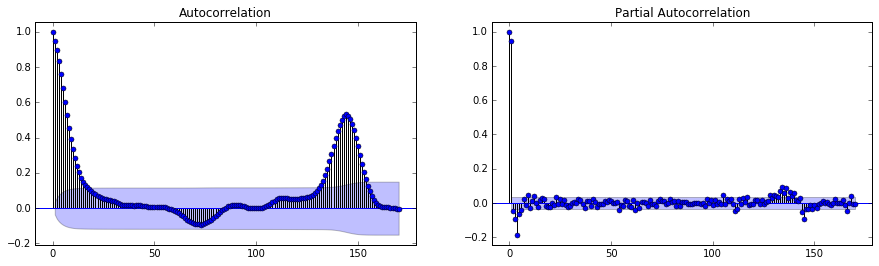

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf (y, lags=170, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(y, lags=170, ax=axes[1])

With 10 minutes steps, 144 steps make 24h, this represent our seasonality as we can see on the autocorrelation and the partial autocorrelation. 

In [7]:
models = {
    'model_4'  : sm.tsa.SARIMAX(y, trend='c',order=(1, 1, 2), seasonal_order=(0, 1, 2, 4 )),
    'model_12' : sm.tsa.SARIMAX(y, trend='c',order=(1, 1, 2), seasonal_order=(0, 1, 2, 12)),
    'model_24' : sm.tsa.SARIMAX(y, trend='c',order=(1, 1, 2), seasonal_order=(0, 1, 2, 24))
}

models_res = {}
for i,c in models.items():
    print "fitting : ", i
    models_res[i] = c.fit()

fitting :  model_24
fitting :  model_4
fitting :  model_12


/home/user/.local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [28]:
def prediction_plot(model_res, y, at_time = '2017-04-21 05:00:00', title='', h=144):
    pred = model_res.get_prediction(start=y.index[-h])
    pred_ci = pred.conf_int()
    # Dynamic predictions
    predict_dy    = model_res.get_prediction(dynamic=pd.to_datetime(at_time).isoformat())
    predict_dy_ci = predict_dy.conf_int()

    # Graph
    fig, ax = plt.subplots(figsize=(15,3))
    plt.title(title)
    # ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

    # Plot data points
    y[-h:].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    pred.predicted_mean.ix[-h:].plot(ax=ax, style='r-', label='One-step-ahead forecast')
    ci = pred_ci.ix[-h:]
    ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.1)
    
    predict_dy.predicted_mean.ix[-h:].plot(ax=ax, style='g--', label='Dynamic forecast')
    ci = predict_dy_ci.ix[-h:]
    ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='g', alpha=0.1)
    
    ax.axvline(x=pd.to_datetime(at_time).isoformat(), ls='--', c='red')
    
    legend = ax.legend(loc='upper right')
    ax.set_ylim([0,4])

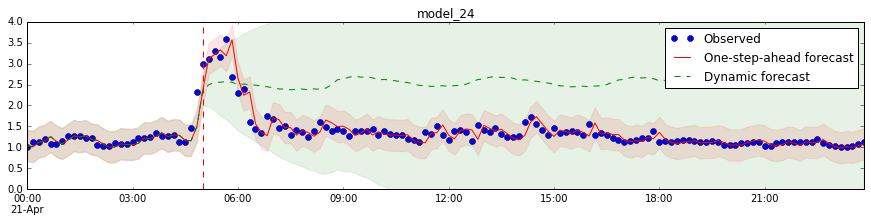

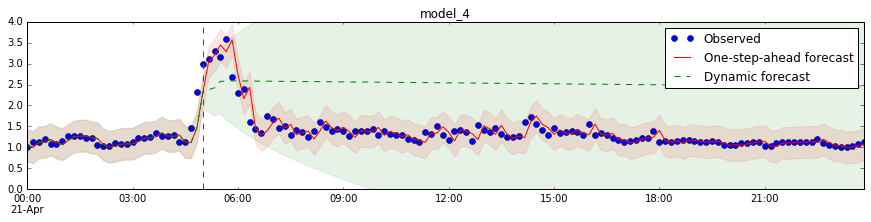

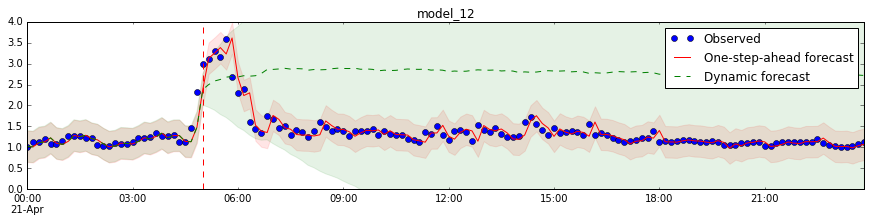

In [12]:
for i,c in models_res.items():
    prediction_plot(c, y, title = i)

In [5]:
yh = df.total_duration_in_traffic.resample('60T').mean()
# last three weeks data : 504 steps
yh = yh[-504:]

In [8]:
hmodels = {
    'model_6'  : sm.tsa.SARIMAX(yh, trend='c',order=(1, 1, 2), seasonal_order=(0, 1, 2, 48)),
    'model_24' : sm.tsa.SARIMAX(yh, trend='c',order=(1, 1, 2), seasonal_order=(0, 1, 2, 24))
}

hmodels_res = {}
for i,c in hmodels.items():
    print "fitting : ", i
    hmodels_res[i] = c.fit()

fitting :  model_24
fitting :  model_6


/home/user/.local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


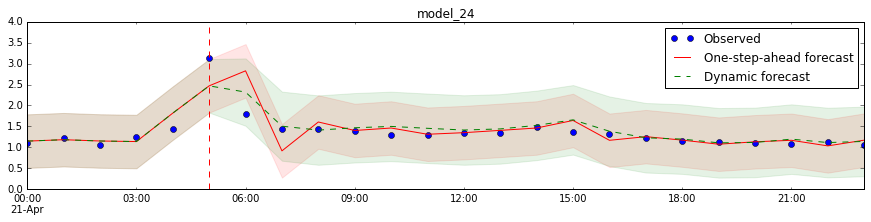

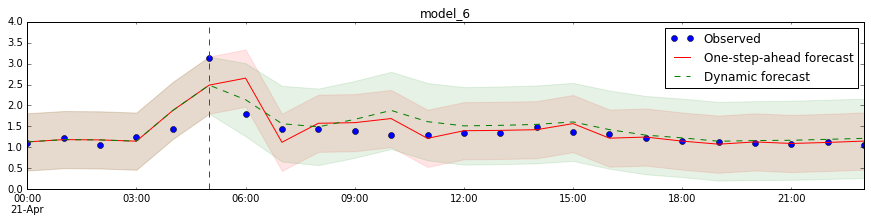

In [29]:
for i,c in hmodels_res.items():
    prediction_plot(c, yh, title = i, h=24,  at_time = '2017-04-21 05:00:00')

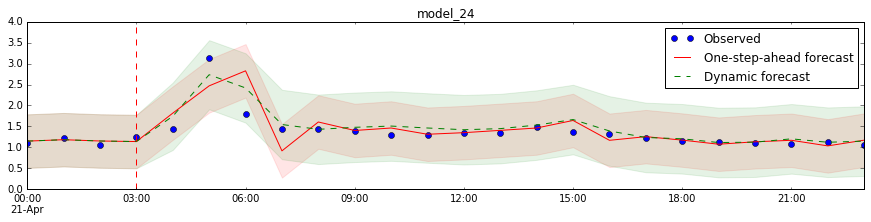

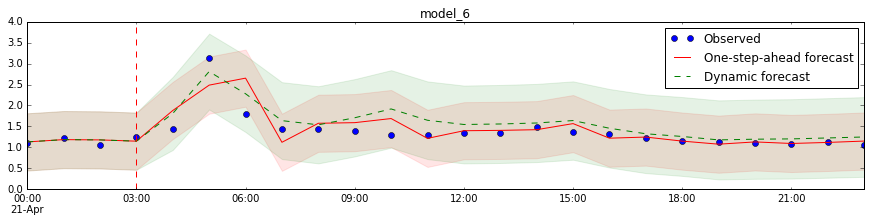

In [30]:
for i,c in hmodels_res.items():
    prediction_plot(c, yh, title = i, h=24,  at_time = '2017-04-21 03:00:00')